# ~~TF-IDF~~ word2vec with Greek

Use this notebook to experiment with calculating ~~TF-IDF~~ word2vec with Greek. 

you're still here! :] that's amazing.

In [5]:
%pip install -r requirements.txt

  Using cached spacy-3.8.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
Reason for being yanked: model compatibility problem
Using cached spacy-3.8.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.4 MB)
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.5
    Uninstalling spacy-3.7.5:
      Successfully uninstalled spacy-3.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grc-proiel-sm 3.7.5 requires spacy<3.8.0,>=3.7.5, but you have spacy 3.8.0 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

df = pd.read_pickle("./greek-tragedy-by-line.pickle")

for i in list(df['text']):
    print(i)

May Zeus who guards suppliants look graciously upon our company, which boarded a ship and put to sea from the outlets of the fine sand of the
whose pastures border
It was Danaus, our father, adviser and leader, who, considering well our course, decided, as the best of all possible evils, that we flee with all speed over the waves of the sea
and find a haven on
could we come with these wool-wreathed branches in our hands, sole weapons of the suppliant? O realm, O land, and clear water;  gods on high and earth-bound powers, grievous in your vengeance,
which inhabit the tomb; and you, Zeus the Savior, invoked third
the thronging swarm of violent men born of
and perish by the tempest’s buffeting blasts, if they ever lay their hands on us, their cousins, and mount unwilling beds from which Right holds them aloof.
And now I invoke, as our champion from beyond the sea, the calf born of Zeus, the offspring of the flower-grazing cow, our ancestress,
the caress of Zeus’ breath. The appointed per

In [7]:
#%pip install tensorflow

import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# if it gets bad, try changing one of these
vocab_size = 4096
sequence_length = 10

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')

def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

# *tim gunn voice* make it work!
text_ds = tf.data.TextLineDataset("plain_drama.txt").filter(lambda x: tf.cast(tf.strings.length(x), bool))

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(text_ds.batch(1024))

inverse_vocab = vectorize_layer.get_vocabulary()

text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()
sequences = list(text_vector_ds.as_numpy_iterator())

targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

2024-12-11 21:51:12.762124: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 21:51:13.101155: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 21:51:13.212793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733953873.428811    2614 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733953873.496796    2614 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 21:51:14.171531: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2145 - loss: 1.6090
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5995 - loss: 1.5921
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6275 - loss: 1.5454
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5539 - loss: 1.4640
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5581 - loss: 1.3773
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5916 - loss: 1.2899
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6310 - loss: 1.2052
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6646 - loss: 1.1249
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6980 - loss: 1.0495
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7258 - loss: 0.9791
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7510 - loss: 0.9135
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7732 - l

## collocation lookup time

In [8]:
for seq in sequences:
  result = f"{seq} => {[inverse_vocab[i] for i in seq]}"

  if "'son'" in result:
    print(result)

son_seqs = [i for i in sequences if 74 in i]
daughter_seqs = [i for i in sequences if 140 in i]

[   1    9   74    4  153  122 1447  897    0    0] => ['[UNK]', 'a', 'son', 'of', 'earth', 'whom', 'hermes', 'slew', '', '']
[   5   87 1317    9   74   26    2 1785    4   25] => ['and', 'zeus', 'begot', 'a', 'son', 'by', 'the', 'touching', 'of', 'his']
[1963   25  817  649   76   64   87   74    4  153] => ['avert', 'his', 'fearful', 'cries', 'o', 'father', 'zeus', 'son', 'of', 'earth']
[  2 113  21 145  41  25  84  74   5 719] => ['the', 'god', 'will', 'give', 'him', 'his', 'own', 'son', 'and', 'declare']
[165 189  40  16  68  12   2  74   4  87] => ['just', 'look', 'at', 'this', 'here', 'is', 'the', 'son', 'of', 'zeus']
[   2   74    4   87   25 3228    5    1   41    8] => ['the', 'son', 'of', 'zeus', 'his', 'labours', 'and', '[UNK]', 'him', 'in']
[2259   74    4    1 1073   23   87    0    0    0] => ['xuthus', 'son', 'of', '[UNK]', 'sprung', 'from', 'zeus', '', '', '']
[  38  566   10   74   13  272 2446   97   28   10] => ['all', 'hail', 'my', 'son', 'that', 'word', 'suits', '

[1144    6  622 2083   11    7    5   17   74    5] => ['hecuba', 'i', 'feel', 'compassion', 'for', 'you', 'and', 'your', 'son', 'and']
[ 12  19  16   7  59 100  17  74   0   0] => ['is', 'it', 'this', 'you', 'would', 'tell', 'your', 'son', '', '']
[  6  21 100  10 390  62  37   9  74   4] => ['i', 'will', 'tell', 'my', 'tale', 'there', 'was', 'a', 'son', 'of']
[   5    2  707 1347   13    9   74    4 1111    1] => ['and', 'the', 'achaeans', 'knowing', 'that', 'a', 'son', 'of', 'priam', '[UNK]']
[  42 1144  330 2217    2   96    4   35   74  205] => ['now', 'hecuba', 'having', 'discovered', 'the', 'death', 'of', 'her', 'son', 'brought']
[360  74   4   0   0   0   0   0   0   0] => ['always', 'son', 'of', '', '', '', '', '', '', '']
[ 6 67  5  2 74  4  0  0  0  0] => ['i', 'see', 'and', 'the', 'son', 'of', '', '', '', '']
[  74    4 2624    7   33  228    0    0    0    0] => ['son', 'of', 'telamon', 'you', 'who', 'hold', '', '', '', '']
[  11  101    4   17   84  154  209   74    4 262

In [22]:
from collections import Counter

son_seqs = [list(i) for i in sequences if 74 in i]
daughter_seqs = [list(i) for i in sequences if 140 in i]

def collocorpus_maker(seqs, word_id):
    res = []

    for seeq in seqs:
        current_indices = []
        #print(type(seeq), seeq)
        fake_list = [int(j) for j in seeq]
       
        if word_id == fake_list[0] :
            current_indices.append(1)
        if fake_list[9] == word_id:
            current_indices.append(8)
        for s in range(1,9):
            if fake_list[s] == word_id:
                current_indices.append(s-1)
                current_indices.append(s+1)
        current_indices = set(current_indices)
        #print(current_indices)
        res.extend([inverse_vocab[seeq[c]] for c in current_indices])
    return res        

son_cnt = Counter(collocorpus_maker(son_seqs, 74))
daughter_cnt = Counter(collocorpus_maker(daughter_seqs, 140))

print(len(son_cnt),"\n", len(daughter_cnt))

#len(collocorpus_maker(son_seqs, 74))
len([i for i in collocorpus_maker(son_seqs, 74) if i != '' and i!='[UNK]'])

164 
 104


579

## anyway, this was a word2vec lab, wasn't it?

let's look at what we've got...


In [10]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


alright, I like the way that looks. let's make a cloud out of all this

In [ ]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

## Sarah's viz corner

In [2]:
%pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<Axes: xlabel='word', ylabel='percent of collocates'>

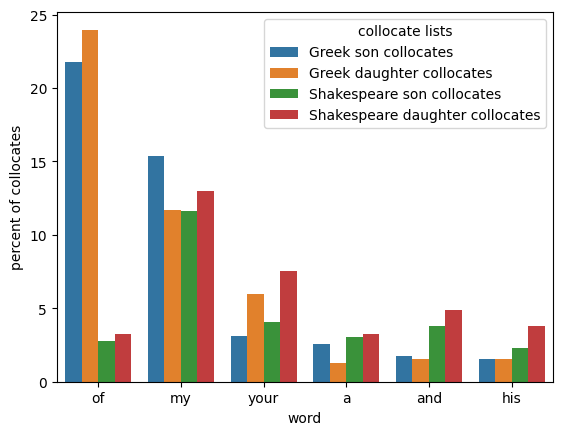

In [21]:
import seaborn as seaboo

words = ["of", "my", "your", "a", "and", "his"]
meta_words = []
meta_words.extend(words)
meta_words.extend(words)
meta_words.extend(words)
meta_words.extend(words)

lists = ['Greek son collocates' for i in words]
lists.extend(['Greek daughter collocates' for i in words])
lists.extend(['Shakespeare son collocates' for i in words])
lists.extend(['Shakespeare daughter collocates' for i in words])

sons_greek = [(i*100)/579 for i in [126, 89, 18, 15, 10, 9]]
sons_greek.extend([(i*100)/317 for i in [76, 37, 19, 4, 5, 5]])
sons_greek.extend([(i*100)/395 for i in [11, 46, 16, 12, 15, 9]])
sons_greek.extend([(i*100)/185 for i in [6, 24, 14, 6, 9, 7]])

coll_results = pd.DataFrame({'word': meta_words, 'collocate lists': lists, 'percent of collocates': sons_greek})

coll_results

seaboo.barplot(data = coll_results,     x="word", y='percent of collocates', hue='collocate lists')